# Parallelization

## FAN IN FAN OUT

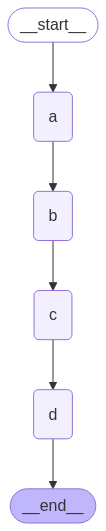

In [35]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret:str):
        self._value = node_secret
    
    def __call__(self, state:State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state":[self._value]}
    
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

Now, let's run `b` and `c` in parallel. 

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

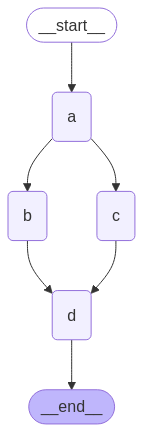

In [37]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
# FAN IN 
builder.add_edge("a", "b")
builder.add_edge("a", "c")
# FAN OUT
builder.add_edge("b", "d")
builder.add_edge("c", "d")

builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**! 

This is because both `b` and `c` are writing to the same state key / channel in the same step. 

In [38]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key. 

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

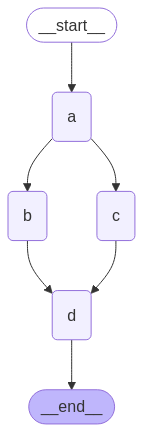

In [39]:
import operator
from typing import Annotated

class State(TypedDict):
    state: Annotated[list, operator.add]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [40]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Waiting for nodes to finish

Now, let's consider a case where one parallel path has more steps than the other one.

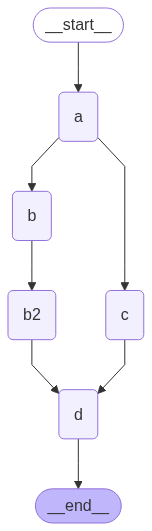

In [41]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2","c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**. 

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

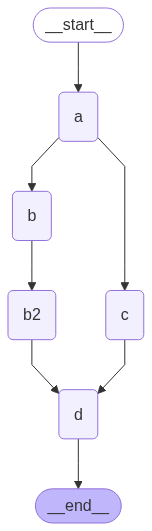

In [43]:
def sorting_reducer(left, right):
    """Combine and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]
    
    if not isinstance(right, list):
        right = [right]

    return sorted(left+right, reverse=False)

class State(TypedDict):
    state: Annotated[list, sorting_reducer]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

## Working with LLMs

In [45]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [46]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

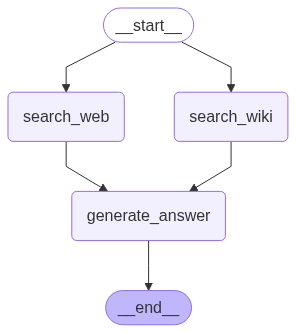

In [47]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):

    """Retrive docs from web search"""

    # Search 
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    # Format
    formatted_search_Docs = "\n\n---\n\n".join(
        [
            f'<Documented href="{doc["url"]}">\n["content"]\n</Document>'
            for doc in search_docs
        ]
    )

    return{"context": [formatted_search_Docs]}

def search_wiki(state):

    """Retrive docs from wikipedia"""
    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()
    
    # Format
    formatted_search_Docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context":[formatted_search_Docs]}

def generate_answer(state):

    # get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

builder = StateGraph(State)
builder.add_node("search_web", search_web)
builder.add_node("search_wiki", search_wiki)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wiki")
builder.add_edge(START, "search_web")
builder.add_edge(["search_web", "search_wiki"], "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
result = graph.invoke({"question": "How were Nivida's Q1 2025 earnings"})
result['answer'].content

"Nvidia's Q1 2025 earnings were very positive, indicating strong financial performance. The reports highlight continued growth in data center revenue and overall robust results, suggesting that Nvidia had a successful quarter."

# Sub-Graphs

[Sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example) allow you to create and manage different states in different parts of your graph. 

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

Let's define a schema for the logs that will be input to our graph.

In [55]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub-graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

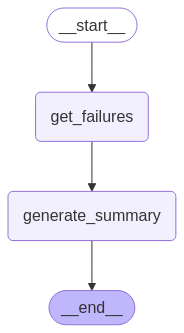

In [56]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

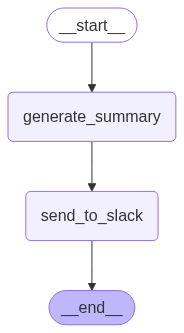

In [57]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph


Now, we can bring it all together.

We create our parent graph with `EntryGraphState`. 

And we add our sub-graphs as nodes! 

In [58]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_logs`.

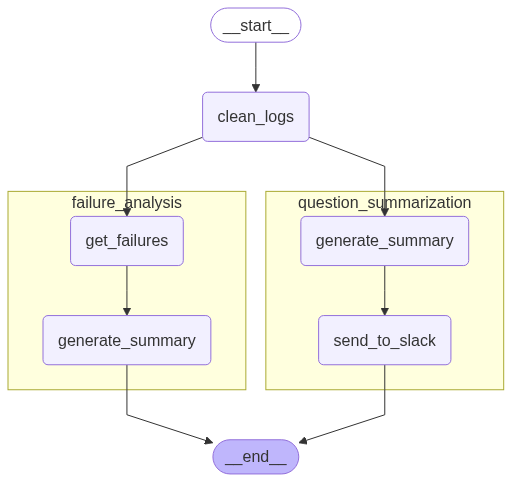

In [59]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [60]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

# Sub-Graphs - 2

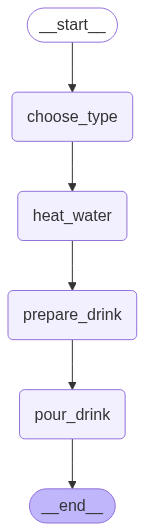

In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# SG-HOT
class HotDrinkState(TypedDict):
    drink_red: str
    HotDrink_Steps: List[str]

def hot_step_1_choose(state: HotDrinkState) -> dict:
    print("  [Hot SG] Node: Choosing type...")
    # Get the current list of steps, add the new step, return the updated list
    return {"HotDrink_Steps": state.get("HotDrink_Steps", []) + ["1. Choose the type of hot drink (coffee, tea, etc.)"]}

def hot_step_2_heat(state: HotDrinkState) -> dict:
    print("  [Hot SG] Node: Heating water...")
    return {"HotDrink_Steps": state.get("HotDrink_Steps", []) + ["2. Heat water."]}

def hot_step_3_prepare(state: HotDrinkState) -> dict:
    print("  [Hot SG] Node: Preparing drink...")
    return {"HotDrink_Steps": state.get("HotDrink_Steps", []) + ["3. Prepare the drink (add coffee/tea, sugar, milk)."]}

def hot_step_4_pour(state: HotDrinkState) -> dict:
    print("  [Hot SG] Node: Pouring...")
    return {"HotDrink_Steps": state.get("HotDrink_Steps", []) + ["4. Pour into a mug."]}

hot_builder = StateGraph(HotDrinkState) 

hot_builder.add_node("choose_type", hot_step_1_choose) 
hot_builder.add_node("heat_water", hot_step_2_heat)
hot_builder.add_node("prepare_drink", hot_step_3_prepare)
hot_builder.add_node("pour_drink", hot_step_4_pour)      

hot_builder.add_edge(START, "choose_type") 
hot_builder.add_edge("choose_type", "heat_water")
hot_builder.add_edge("heat_water", "prepare_drink")
hot_builder.add_edge("prepare_drink", "pour_drink")
hot_builder.add_edge("pour_drink", END)

compiled_hot_graph  = hot_builder.compile()
display(Image(compiled_hot_graph.get_graph().draw_mermaid_png()))

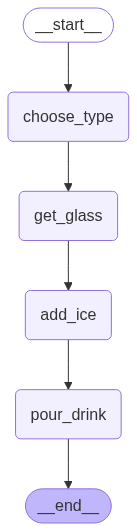

In [ ]:
# SG-COLD
class ColdDrinkState(TypedDict):
    drink_red: str
    ColdDrink_Steps: List[str]

def cold_step_1_choose(state: ColdDrinkState) -> dict:
    print("  [Cold SG] Node: Choosing type...")
    return {"ColdDrink_Steps": state.get("ColdDrink_Steps", []) + ["1. Choose the type of cold drink (juice, soda, water)."]}

def cold_step_2_glass(state: ColdDrinkState) -> dict:
    print("  [Cold SG] Node: Getting glass...")
    return {"ColdDrink_Steps": state.get("ColdDrink_Steps", []) + ["2. Get a glass."]}

def cold_step_3_ice(state: ColdDrinkState) -> dict:
    print("  [Cold SG] Node: Adding ice...")
    return {"ColdDrink_Steps": state.get("ColdDrink_Steps", []) + ["3. Add ice (optional)."]}

def cold_step_4_pour(state: ColdDrinkState) -> dict:
    print("  [Cold SG] Node: Pouring...")
    return {"ColdDrink_Steps": state.get("ColdDrink_Steps", []) + ["4. Pour the drink into the glass."]}

cold_builder = StateGraph(ColdDrinkState) 
cold_builder.add_node("choose_type", cold_step_1_choose)
cold_builder.add_node("get_glass", cold_step_2_glass)
cold_builder.add_node("add_ice", cold_step_3_ice)
cold_builder.add_node("pour_drink", cold_step_4_pour)

cold_builder.add_edge(START, "choose_type") 
cold_builder.add_edge("choose_type", "get_glass")
cold_builder.add_edge("get_glass", "add_ice")
cold_builder.add_edge("add_ice", "pour_drink")
cold_builder.add_edge("pour_drink", END)

compiled_cold_graph  = cold_builder.compile()
display(Image(compiled_cold_graph.get_graph().draw_mermaid_png()))

In [84]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs = Optional[Log]
    drink_req: str
    decision: Optional[str]
    HotDrink_Steps: Optional[List[str]]
    ColdDrink_Steps: Optional[List[str]]
    final_message = Optional[str]

def decide_drink_type(state: EntryGraphState)-> dict:
    print("\n[Entry Graph]: Deciding drink type...")
    request = state['drink_req'].lower()
    decision = None
    if 'hot' in request:
        decision = 'hot'
        print("[Entry Graph] Decsiion: Hot drink requested.")
    elif 'cold' in request:
        decision = 'cold'
        print("[Entry Graph] Decision: Cold drink requested.")
    else:
        decision = "cold" 
        print(f"[Main Graph] Could not determine hot or cold from '{request}'. Defaulting to cold.")
    
    return {"decision": decision}

def format_final_answer(state: EntryGraphState) -> dict:
    print("\n[Entry Graph] Node: Formatting final answer...")
    message = "Here are the steps taken:\n"
    if state.get("HotDrink_Steps"):
        message += "- Hot Drink Steps:\n" + "\n".join(state["HotDrink_Steps"])
    elif state.get("ColdDrink_Steps"):
         message += "- Cold Drink Steps:\n" + "\n".join(state["ColdDrink_Steps"])
    else:
        message += "No specific drink steps were recorded (something went wrong or input was unclear)."

    print("[Entry Graph] Formatted Message:\n", message)
    return {"final_message": message}

def route_to_subgraph(state: EntryGraphState) -> str:
    """
    This function determines which node to go to next based on the 'decision' state.
    It returns the *name* of the next node in the entry graph.
    """
    print(f"\n[Entry Graph] Routing based on decision: {state.get('decision')}")
    if state.get("decision") == "hot":
        return "hot_drink_flow_node"
    elif state.get("decision") == "cold":
        return "cold_drink_flow_node"
    else:
        print("[Entry Graph] Routing Error: No valid decision found in state during routing.")
        return "cold_drink_flow_node"

main_builder = StateGraph(EntryGraphState) 

main_builder.add_node("decide_drink_type_node", decide_drink_type)
main_builder.add_node("format_final_answer_node", format_final_answer)

main_builder.add_node("hot_drink_flow_node", compiled_hot_graph)
main_builder.add_node("cold_drink_flow_node", compiled_cold_graph)

main_builder.add_edge(START, "decide_drink_type_node") 

main_builder.add_conditional_edges(
    "decide_drink_type_node", 
    route_to_subgraph)

main_builder.add_edge("hot_drink_flow_node", "format_final_answer_node")
main_builder.add_edge("cold_drink_flow_node", "format_final_answer_node")
main_builder.add_edge("format_final_answer_node", END)

compiled_main_graph = main_builder.compile()
# display(Image(compiled_main_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [85]:
print("\n" + "="*50)
print("   --- Running Example 1: Make a hot drink ---")
print("="*50)
initial_state = {"drink_req": "Make me a hot drink please!"}
result = compiled_main_graph.invoke(initial_state)
print("\nFinal State:", result)


   --- Running Example 1: Make a hot drink ---

[Entry Graph]: Deciding drink type...
[Entry Graph] Decsiion: Hot drink requested.

[Entry Graph] Routing based on decision: hot
  [Hot SG] Node: Choosing type...
  [Hot SG] Node: Heating water...
  [Hot SG] Node: Preparing drink...
  [Hot SG] Node: Pouring...

[Entry Graph] Node: Formatting final answer...
[Entry Graph] Formatted Message:
 Here are the steps taken:
- Hot Drink Steps:
1. Choose the type of hot drink (coffee, tea, etc.)
2. Heat water.
3. Prepare the drink (add coffee/tea, sugar, milk).
4. Pour into a mug.

Final State: {'drink_req': 'Make me a hot drink please!', 'decision': 'hot', 'HotDrink_Steps': ['1. Choose the type of hot drink (coffee, tea, etc.)', '2. Heat water.', '3. Prepare the drink (add coffee/tea, sugar, milk).', '4. Pour into a mug.']}


In [86]:
print("\n" + "="*50)
print("   --- Running Example 2: Make a cold drink ---")
print("="*50)
initial_state = {"drink_req": "Make me a cold lemonade please!"}
result = compiled_main_graph.invoke(initial_state)
print("\nFinal State:", result)


   --- Running Example 2: Make a cold drink ---

[Entry Graph]: Deciding drink type...
[Entry Graph] Decision: Cold drink requested.

[Entry Graph] Routing based on decision: cold
  [Cold SG] Node: Choosing type...
  [Cold SG] Node: Getting glass...
  [Cold SG] Node: Adding ice...
  [Cold SG] Node: Pouring...

[Entry Graph] Node: Formatting final answer...
[Entry Graph] Formatted Message:
 Here are the steps taken:
- Cold Drink Steps:
1. Choose the type of cold drink (juice, soda, water).
2. Get a glass.
3. Add ice (optional).
4. Pour the drink into the glass.

Final State: {'drink_req': 'Make me a cold lemonade please!', 'decision': 'cold', 'ColdDrink_Steps': ['1. Choose the type of cold drink (juice, soda, water).', '2. Get a glass.', '3. Add ice (optional).', '4. Pour the drink into the glass.']}


# Map-Reduce

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [87]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4.1-nano', temperature=0)

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

Generate subjects for jokes

In [103]:
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state['topic'])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [104]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

Map - Joke Generation

In [105]:
joke_prompt = """Generate a joke about {subject}"""

class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

Reduce - Best Joke Selection

In [106]:
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

Graph Build and Compile

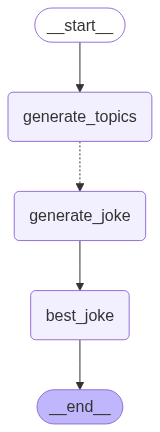

In [107]:
from IPython.display import Image
from langgraph.graph import START, StateGraph, END

builder = StateGraph(OverallState)

builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

builder.add_edge(START, "generate_topics")
builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)

app = builder.compile()
Image(app.get_graph().draw_mermaid_png())

In [108]:
for s in app.stream({'topic': "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Wildlife conservation', 'Animal behavior and communication', 'Domesticated animals and pet care']}}
{'generate_joke': {'jokes': ['Why did the squirrel bring a tiny megaphone to the tree? Because it wanted to be heard in the nut-ural communication network!']}}
{'generate_joke': {'jokes': ['Why did the endangered zebra start a conservation blog? Because it wanted to keep its stripes in the spotlight!']}}
{'generate_joke': {'jokes': ['Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse and stay domesticated in style!']}}
{'best_joke': {'best_selected_joke': 'Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse and stay domesticated in style!'}}


# Research Assistant



Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

Goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

## Generate Analysts: HIL

In [109]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4.1-nano', temperature=0)

In [118]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst"
    )
    name: str = Field(
        description="Name of the analyst"
    )
    role: str = Field(
        description="Role of the analyst on the content of the topic"
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives"
    )
    @property
    def persona(self)-> str:
        return f"Nmae: {self.name}\nRole:{self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprenhensive list of analyst with their roles and affiliations."
    )

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

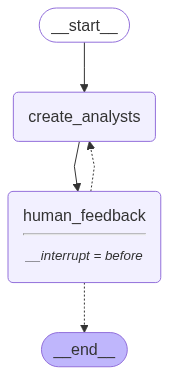

In [119]:
from IPython.display import Image
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get('human_analyst_feedback', "")

    structured_llm = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback, max_analysts=max_analysts)

    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

    return {"analysts": analysts.analysts}

def human_feedack(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
    
    return END

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedack)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ['create_analysts', END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

Image(graph.get_graph(xray=True).draw_mermaid_png())

In [120]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Alice Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Focuses on how LangGraph can streamline agent deployment and improve operational efficiency, aiming to promote faster adoption of agent frameworks.
--------------------------------------------------
Name: Prof. Benjamin Lee
Affiliation: AI Research Lab
Role: AI Theorist and Ethical Expert
Description: Examines the ethical implications and theoretical benefits of LangGraph, emphasizing responsible AI development and long-term societal impacts.
--------------------------------------------------
Name: Sara Martinez
Affiliation: Enterprise Solutions Ltd.
Role: Business Strategist and Implementation Consultant
Description: Analyzes the practical benefits of LangGraph for enterprise integration, including scalability, customization, and ROI, to guide organizations in strategic adoption.
--------------------------------------------------


In [121]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [122]:
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0366e8-08db-64ed-8002-10381e05ad04'}}

In [123]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Alice Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Focuses on how LangGraph can streamline agent deployment and improve operational efficiency, aiming to promote faster adoption of agent frameworks.
--------------------------------------------------
Name: Prof. Benjamin Lee
Affiliation: AI Research Lab
Role: AI Theorist and Ethical Expert
Description: Examines the ethical implications and theoretical benefits of LangGraph, emphasizing responsible AI development and long-term societal impacts.
--------------------------------------------------
Name: Sara Martinez
Affiliation: Enterprise Solutions Ltd.
Role: Business Strategist and Implementation Consultant
Description: Analyzes the practical benefits of LangGraph for enterprise integration, including scalability, customization, and ROI, to guide organizations in strategic adoption.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: LangTech Innovatio

In [124]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0366e9-26e8-650f-8004-73222d8b9aa1'}}

In [127]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [128]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [129]:
final_state.next

()

In [130]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: LangTech Innovations
Role: AI Framework Researcher
Description: Specializes in evaluating the technical advantages of LangGraph as an agent framework, focusing on scalability, flexibility, and integration capabilities.
--------------------------------------------------
Name: Alex Ramirez
Affiliation: Startup Founders Network
Role: Entrepreneur & Startup Founder
Description: Brings an entrepreneurial perspective on how LangGraph can accelerate startup development, improve agility, and reduce time-to-market for innovative AI solutions.
--------------------------------------------------
Name: Sophie Lee
Affiliation: Tech Industry Analysts Inc.
Role: Industry Analyst
Description: Provides insights into the broader industry implications of adopting LangGraph, including competitive advantages and market trends.
--------------------------------------------------


# Conduct Interview

Generate Question

The analyst will ask questions to the expert

In [131]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, 
                              description="Search query for retriveal.")


In [132]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


In [135]:
def generate_question(state: InterviewState):
    """Node to generate a question"""

    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    return {"messages":[question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [136]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=3)

In [138]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

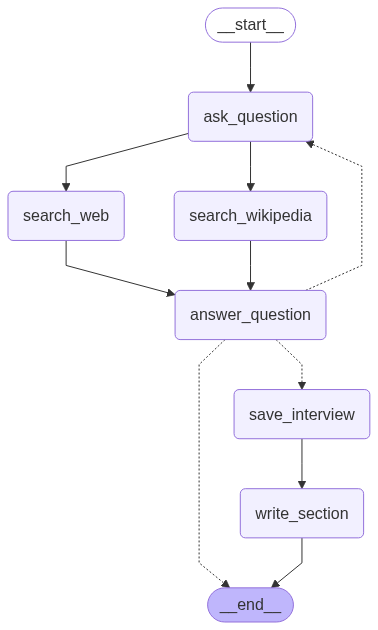

In [140]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [142]:
analysts[0]

Analyst(affiliation='LangTech Innovations', name='Dr. Emily Chen', role='AI Framework Researcher', description='Specializes in evaluating the technical advantages of LangGraph as an agent framework, focusing on scalability, flexibility, and integration capabilities.')

In [145]:
from IPython.display import Markdown
messages = [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
thread = {"configurable":{"thread_id":"1"}}
interview = interview_graph.invoke({"analyst":analysts[0], "messages":messages, "max_num_turns":2}, thread)
Markdown(interview['sections'][0])

## Evaluating the Technical Advantages of LangGraph for Scalable, Flexible, and Integrable Agent Frameworks

### Summary

LangGraph emerges as a compelling agent framework within the broader ecosystem of AI development, distinguished by its visual, graph-based approach to designing multi-agent workflows. Unlike traditional text-centric frameworks such as LangChain, which prioritize flexibility and deep integration with large language models (LLMs), LangGraph emphasizes intuitive visualization, structured coordination, and scalability, making it particularly suitable for complex, enterprise-level applications. Its core strength lies in simplifying the development of multi-agent systems by enabling developers to define, coordinate, and execute multiple LLM agents through explicit graph structures, which inherently support complex dependencies and interactions [1][2].

One of the most novel aspects of LangGraph is its focus on visualizing task dependencies and communication protocols, which helps prevent common issues like race conditions and deadlocks in multi-agent systems. This explicit coordination model enhances manageability and robustness, especially in scenarios involving hierarchical or nested agent workflows [3][4]. Additionally, LangGraph’s support for statefulness, human-in-the-loop workflows, and streaming capabilities makes it highly adaptable for real-time, interactive applications, including collaborative human-AI systems [2][4].

From a scalability perspective, LangGraph is architected to handle high volumes of interactions and complex workflows, making it suitable for enterprise deployments where performance and reliability are critical. Its ability to coordinate multiple agents, each potentially operating as subgraphs, allows for modular, hierarchical system design, which can grow in complexity without sacrificing manageability [2][4]. Furthermore, LangGraph’s integration with IoT and other external systems demonstrates its flexibility in real-world, multi-modal environments, enabling seamless data exchange and operational automation [5].

In summary, LangGraph’s novel visual approach, combined with its focus on structured coordination, scalability, and integration, positions it as a powerful framework for building sophisticated multi-agent AI systems. Its emphasis on transparency and manageability addresses key challenges in multi-agent development, making it a promising choice for organizations seeking to deploy complex, reliable, and adaptable AI workflows.

### Sources
[1] https://oxylabs.io/blog/langgraph-vs-langchain/  
[2] https://www.datacamp.com/tutorial/langgraph-tutorial  
[3] https://langchain-ai.github.io/langgraph/concepts/multi_agent/  
[4] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[5] https://rapidinnovation.io/post/ai-agents-in-langgraph

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [146]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str

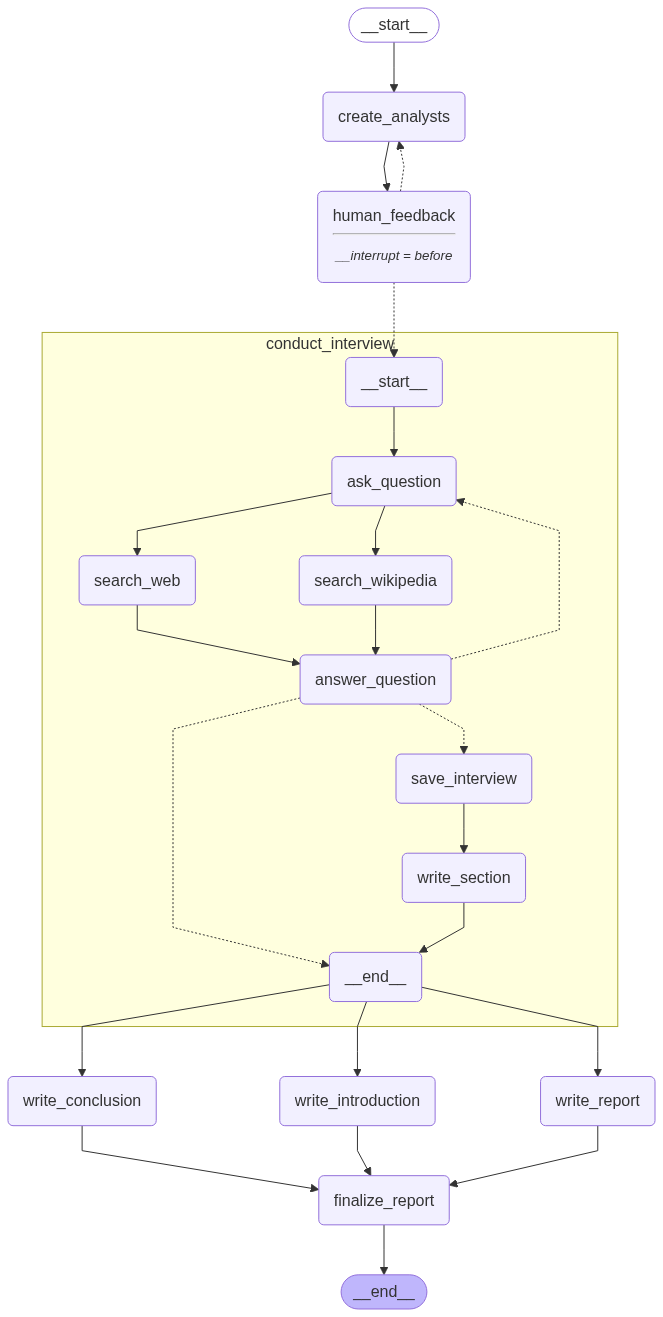

In [149]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

def human_feedback(state: MessagesState):
    pass

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [150]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Alice Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Focused on evaluating how LangGraph enhances agent frameworks, improving efficiency and scalability for enterprise applications.
--------------------------------------------------
Name: Prof. Brian Lee
Affiliation: Academic Research Labs
Role: Academic Researcher in AI Frameworks
Description: Explores the theoretical benefits of LangGraph, including its impact on AI agent interoperability and development ease.
--------------------------------------------------
Name: Ms. Clara Martinez
Affiliation: Industry Consulting Firm
Role: Industry Analyst and Strategist
Description: Assesses the strategic advantages for businesses adopting LangGraph, emphasizing ROI, competitive edge, and integration challenges.
--------------------------------------------------


In [151]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03737a-bad7-634c-8002-b0e489655e7f'}}

In [152]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Alice Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Focused on evaluating how LangGraph enhances agent frameworks, improving efficiency and scalability for enterprise applications.
--------------------------------------------------
Name: Prof. Brian Lee
Affiliation: Academic Research Labs
Role: Academic Researcher in AI Frameworks
Description: Explores the theoretical benefits of LangGraph, including its impact on AI agent interoperability and development ease.
--------------------------------------------------
Name: Ms. Clara Martinez
Affiliation: Industry Consulting Firm
Role: Industry Analyst and Strategist
Description: Assesses the strategic advantages for businesses adopting LangGraph, emphasizing ROI, competitive edge, and integration challenges.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: LangTech Innovations
Role: AI Framework Researcher
Description: Specializes in evaluating the techn

In [153]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03737b-94f4-6a5f-8004-3f7b5fc088ad'}}

In [154]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [155]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking the Future of AI with LangGraph

## Introduction

This report explores the transformative benefits of adopting LangGraph as an agent framework, highlighting its unique ability to build scalable, flexible, and stateful multi-agent systems. We examine its technical advantages, including cyclical workflows, robust state management, and fine-grained control over agent behaviors. The report also discusses practical applications, industry insights, and the framework’s potential to accelerate AI innovation. By understanding these core aspects, organizations can leverage LangGraph to develop more intelligent, adaptable, and ethically aligned AI solutions that meet the demands of complex, real-world environments.

---



LangGraph is emerging as a highly versatile and powerful framework for developing complex, stateful multi-agent AI systems. Its core strength lies in its explicit support for cyclical workflows, which distinguishes it from traditional DAG-based frameworks. This cyclical capability enables agents to re-enter processes, refine their reasoning, and adapt dynamically based on previous interactions, making it particularly suitable for applications requiring iterative decision-making, such as virtual assistants, customer service bots, and decision support systems across various industries [1].

One of the most significant advantages of LangGraph is its robust state management features. These allow agents to maintain conversational context over extended interactions, ensuring continuity and coherence in multi-turn dialogues. This persistent state tracking enhances the agents’ ability to handle complex decision trees and long-term workflows, reducing errors and improving user engagement [1][2]. The graph-based representation of workflows, where nodes represent agents or functions and edges define flow, provides fine-grained control over decision logic, branching, and looping, facilitating the creation of highly customized and sophisticated multi-agent architectures.

Furthermore, LangGraph’s design supports large-scale, multi-agent systems that can operate collaboratively. Its flexibility in handling conditional logic, streaming data, and human-in-the-loop workflows makes it adaptable to real-world scenarios involving automation, complex data analysis, and hierarchical control structures [2][3]. The framework’s reflection capabilities, inspired by advanced graph algorithms, enable agents to analyze their past actions and feedback, fostering continuous learning and improvement over time. This adaptability is crucial for organizations aiming to deploy AI solutions that evolve with user needs and operational demands.

In addition to technical robustness, LangGraph promotes ethical and transparent AI development. Its ability to reference past states and adapt responses accordingly aligns with principles of fairness and user trust. The modular, graph-based architecture also enhances safety and scalability, making it suitable for deployment in sensitive or high-stakes environments such as healthcare, finance, and autonomous systems [3].

Overall, LangGraph offers a compelling combination of flexibility, scalability, and control, positioning it as a leading framework for building next-generation AI agents. Its support for iterative, context-aware workflows enables organizations to develop smarter, more reliable, and ethically aligned AI systems that can operate effectively over the long term.


---

## Conclusion

LangGraph stands out as a transformative framework for building advanced, stateful multi-agent systems. Its support for cyclical workflows, robust state management, and flexible graph-based architecture enables the development of intelligent, adaptable, and scalable AI applications. By facilitating iterative reasoning, context preservation, and complex decision-making, LangGraph empowers organizations to create more reliable and personalized AI solutions. Its capacity to handle multi-agent collaboration and human-in-the-loop workflows positions it as a critical tool for future AI innovation. Embracing LangGraph unlocks new possibilities for scalable, ethical, and long-term AI deployment across diverse industries.

## Sources

[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03/  
[2] https://www.getzep.com/ai-agents/langchain-agents-langgraph  
[3] https://www.akira.ai/blog/ai-agent-coordination-with-langgrap